In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv')

data['malade'] = data['malade'].astype(int)
data['malade'] = data['malade'].astype(str)

# Paramètres du modèle

input_shape = (256, 256, 3)  
num_classes = len(data.malade.unique())


data.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
1,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
2,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
3,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
4,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab


### Division du jeu de données en 10 dataframes équilibrés

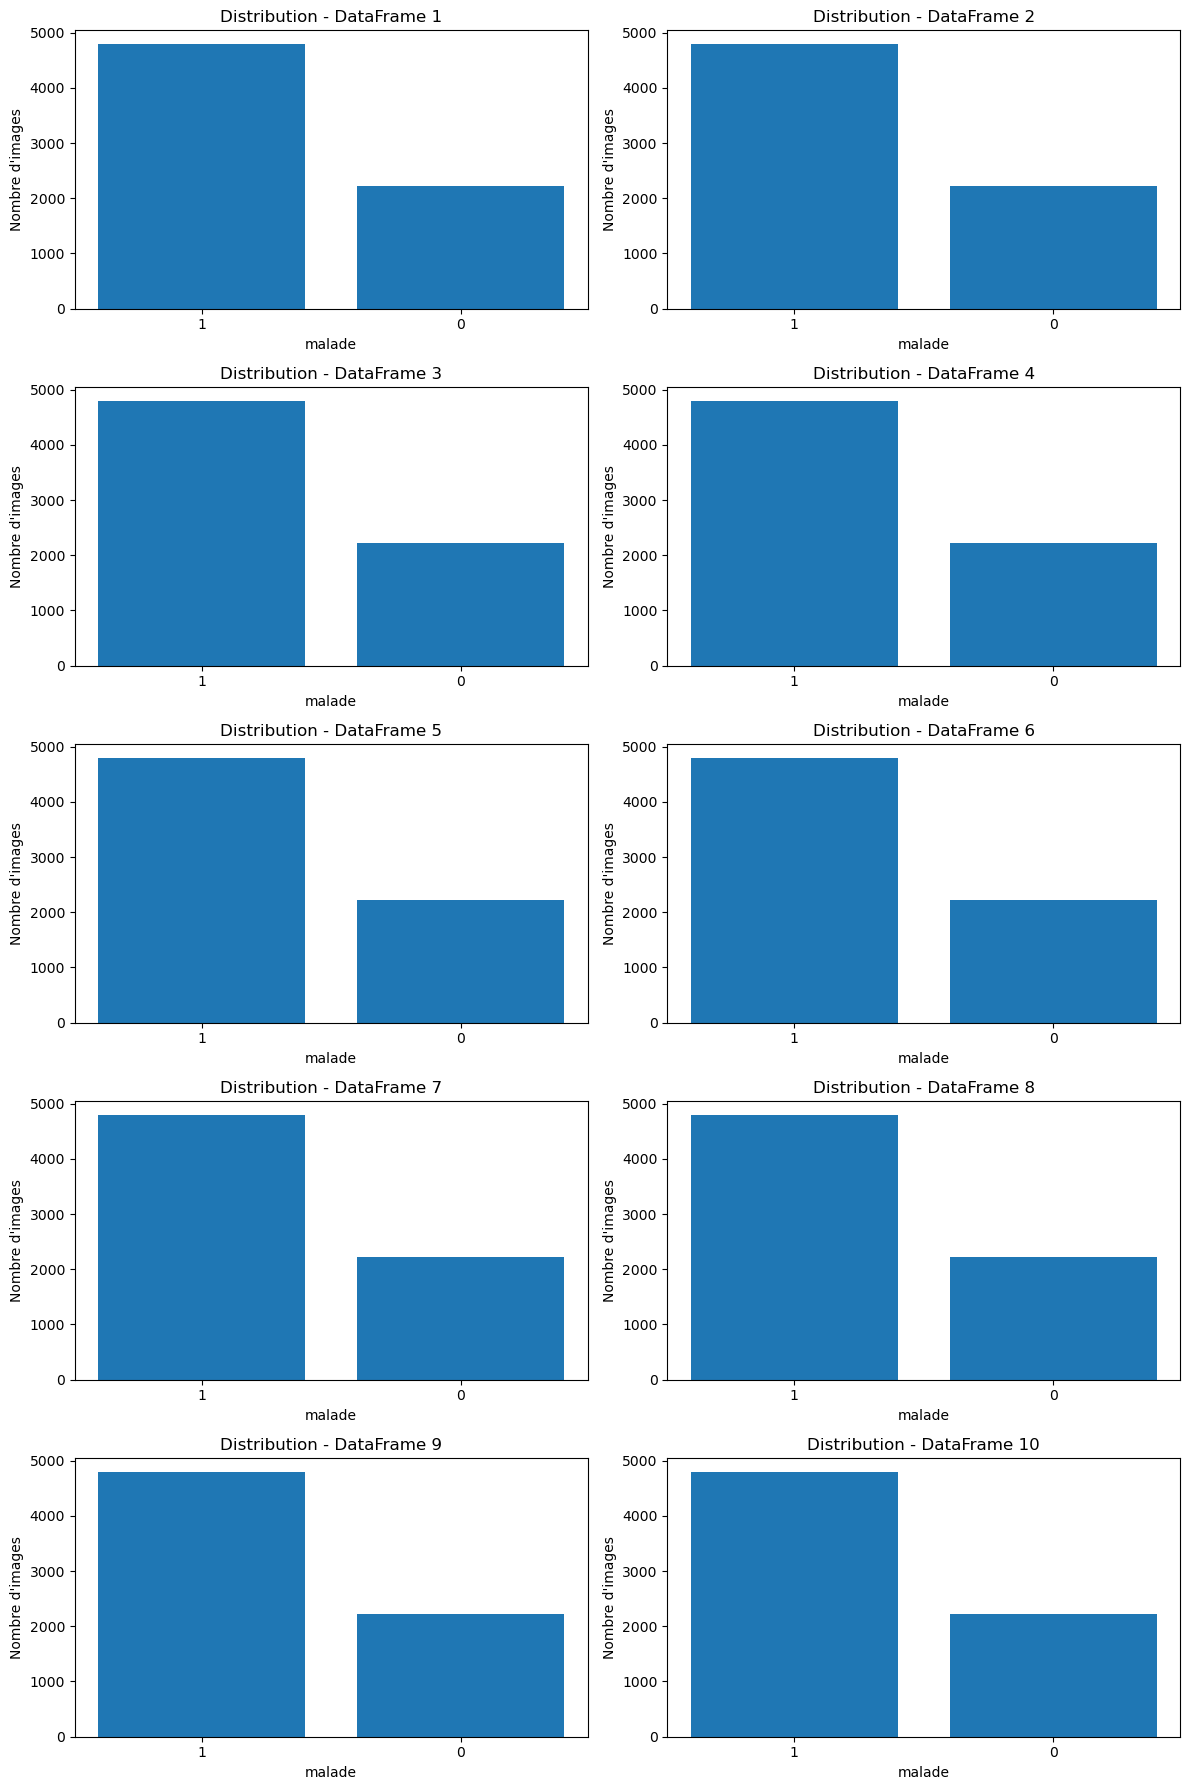

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data.drop(['espece', 'malade', 'nom_maladie'], axis=1)
y = data['malade']

dfs = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9)
for train_index, _ in sss.split(X, y):
    df = pd.concat([X.iloc[train_index].reset_index(drop=True), y.iloc[train_index].reset_index(drop=True)], axis=1)
    dfs.append(df)

fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i, df in enumerate(dfs):
    value_counts = df['malade'].value_counts()
    
    row = i // 2
    col = i % 2
    
    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_title(f"Distribution - DataFrame {i+1}")
    axs[row, col].set_xlabel("malade")
    axs[row, col].set_ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

### Prétraitement des données 

In [3]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generators = []
validation_generators = []

for i in range(10):
    data_i = dfs[i]  
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="malade",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='binary',
        subset='training'
    )
    train_generators.append(train_generator)
    
    validation_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="malade",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='binary',
        subset='validation'
    )
    validation_generators.append(validation_generator)

Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated ima

### Modèle

In [4]:
# VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freezing

for layer in base_model.layers:
    layer.trainable = False

# Nouvelles couches 

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compilation

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [5]:
checkpoint_callback = ModelCheckpoint(
    'tf_VGG16_id_malade.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Boucle pour entraîner le modèle pour chaque data_i

for i in range(5):
    train_generator_i = train_generators[i]
    validation_generator_i = validation_generators[i]

    print(f"Entraînement du modèle pour data_{i+1} :")

    history = model.fit(
        train_generator_i,
        steps_per_epoch=train_generator_i.samples // train_generator_i.batch_size,
        epochs=8,
        validation_data=validation_generator_i,
        validation_steps=validation_generator_i.samples // validation_generator_i.batch_size,
        callbacks=[checkpoint_callback]
    )

    print(f"Fin de l'entraînement du modèle pour data_{i+1}.")
    print()

Entraînement du modèle pour data_1 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.7613
Epoch 1: val_accuracy improved from -inf to 0.79390, saving model to tf_VGG16_id_malade.h5
87/87 [==============================] - 811s 9s/step - loss: 0.4758 - accuracy: 0.7613 - val_loss: 0.3998 - val_accuracy: 0.7939
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 0.3598 - accuracy: 0.8475
Epoch 2: val_accuracy improved from 0.79390 to 0.86682, saving model to tf_VGG16_id_malade.h5
87/87 [==============================] - 857s 10s/step - loss: 0.3598 - accuracy: 0.8475 - val_loss: 0.3146 - val_accuracy: 0.8668
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.8795
Epoch 3: val_accuracy improved from 0.86682 to 0.89137, saving model to tf_VGG16_id_malade.h5
87/87 [==============================] - 859s 10s/step - loss: 0.3018 - accuracy: 0.8795 - val_loss: 0.2669 - val_accuracy: 0.8914
Epoch 4/8
87/

87/87 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9446
Epoch 4: val_accuracy did not improve from 0.95312
87/87 [==============================] - 871s 10s/step - loss: 0.1426 - accuracy: 0.9446 - val_loss: 0.1353 - val_accuracy: 0.9472
Epoch 5/8
87/87 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9496
Epoch 5: val_accuracy did not improve from 0.95312
87/87 [==============================] - 870s 10s/step - loss: 0.1332 - accuracy: 0.9496 - val_loss: 0.1275 - val_accuracy: 0.9494
Epoch 6/8
87/87 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9522
Epoch 6: val_accuracy did not improve from 0.95312
87/87 [==============================] - 876s 10s/step - loss: 0.1351 - accuracy: 0.9522 - val_loss: 0.1193 - val_accuracy: 0.9516
Epoch 7/8
87/87 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9531
Epoch 7: val_accuracy improved from 0.95312 to 0.95387, saving model to tf_VGG16_id_malade.h

### Test du modèle sur les données de validation

In [6]:
data_test = pd.read_csv('data_test.csv')

data_test['malade'] = data_test['malade'].astype(int)
data_test['malade'] = data_test['malade'].astype(str)


data_test.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
1,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
2,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
3,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab
4,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,1,Apple_scab


In [7]:
# Prétraitement des images

image_size = (256, 256)
batch_size = 64

datagen = ImageDataGenerator(rescale=1.0/255.0)

data_generator = datagen.flow_from_dataframe(
    dataframe=data_test,
    x_col='img_path',
    y_col='malade',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=False  
)


Found 17572 validated image filenames belonging to 2 classes.


In [8]:
# Chargement du modèle

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.load_weights('tf_VGG16_id_malade.h5')

# Compilation 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Sauvegarde du modèle

model.save('model_tf_VGG16_id_malade.h5')

In [9]:
import numpy as np

# Seuil pour déterminer la classe prédite
threshold = 0.5

# Prédiction des probabilités
predictions = model.predict(data_generator)

# Conversion des probabilités en classes prédites (0 ou 1)
predicted_labels = (predictions > threshold).astype(int)

275/275 [==============================] - 2291s 8s/step


In [10]:
true_labels = data_generator.classes
class_labels = data_generator.class_indices

Accuracy : 95.73%


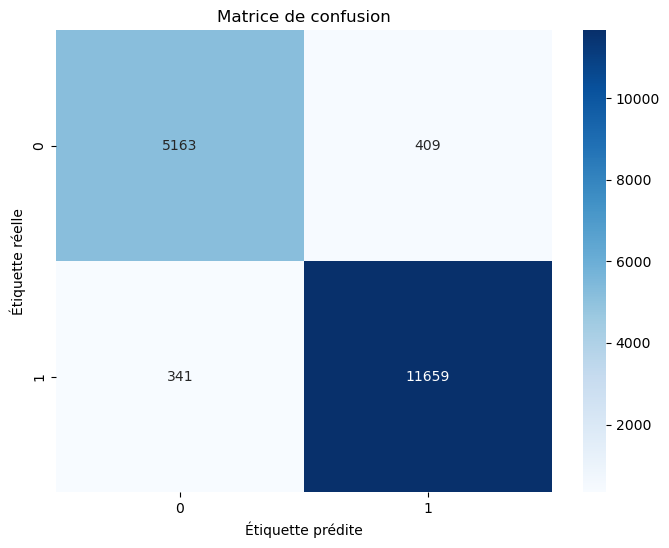

In [11]:
# Évaluation

from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy : {:.2f}%".format(accuracy * 100))

import seaborn as sns

confusion = confusion_matrix(true_labels, predicted_labels)

class_labels = np.unique(true_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matrice de confusion")
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.show()